In [127]:
import os
import re
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

from src.config import DataFoldersConfig

os.chdir(r"C:\Users\Vladyslav_Synytsia\my_projects\to_be_named")

# Data Loading

In [94]:
preprocessed_data_folder = Path(DataFoldersConfig.PREPROCESSED)
data = pd.read_csv(preprocessed_data_folder / "reviews.csv")

In [92]:
data.head()

,url,artist_name,label,album_name,genre,score,text
0,https://pitchfork.com/reviews/albums/nicki-min...,Nicki Minaj,Young Money Entertainment / Republic,Pink Friday 2,Rap,6.5,Thirteen years after her landmark album Pink F...
1,https://pitchfork.com/reviews/albums/epilogio-...,Epilogio,self-released,Cromo Rx,Rock,7.6,The Puerto Rican quartet blends streamlined ps...
2,https://pitchfork.com/reviews/albums/rod-stewa...,Rod Stewart,Mercury,Every Picture Tells a Story,Rock,9.4,"Each Sunday, Pitchfork takes an in-depth look ..."
3,https://pitchfork.com/reviews/albums/james-elk...,James Elkington,No Quarter,Me Neither,Folk/Country,7.5,"On an adventurous new album, the guitarist ble..."
4,https://pitchfork.com/reviews/albums/pelada-ah...,Pelada,New Label,Ahora Más Que Nunca,Electronic,7.7,The Montreal duo’s scorching second album unit...


# Visualizations

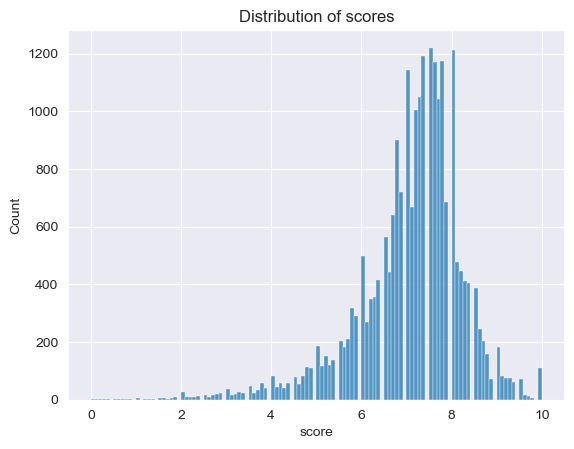

In [14]:
sns.histplot(data.score).set(title="Distribution of scores");

As we can see, score follows approximately skewed normal distribution, with the majority of reviews having score of either 7 or 8, with interesting peak at 10. 
Let's see how score correlates with length of text review.

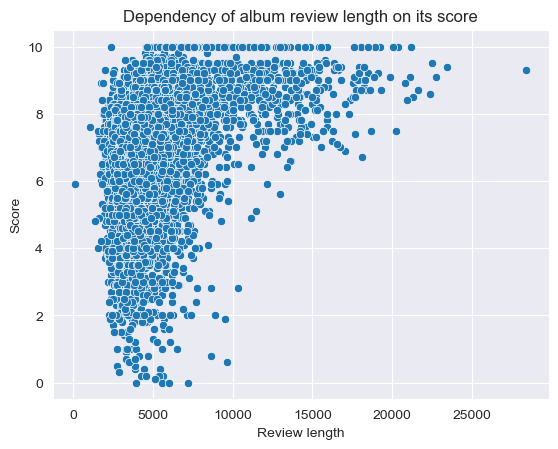

In [15]:
text_review_lengths = data.text.str.len()
sns.scatterplot(x=text_review_lengths, y=data.score).set(
    title="Dependency of album review length on its score",
    xlabel="Review length",
    ylabel="Score"
);

We can observe a log-like dependency: the longer text review is, the higher album score is. 
Let's see distribution of top rated artists based on different properties.
First, let's see which artists are on average rated the highest

In [16]:
# Auxiliary function

def get_top_k_rated(df: pd.DataFrame, who: str, top_k: int = 10) -> pd.DataFrame:
    return (df
            .groupby(who)
            .filter(lambda x: len(x) >= 3)
            .groupby(who)
            .agg({"score": "mean"})
            .sort_values("score", ascending=False)
            .head(top_k)
            )

In [17]:
top_10_rated_artists = get_top_k_rated(data, who="artist_name")
top_10_rated_artists

,score
artist_name,
D’Angelo,9.533333
The Velvet Underground,9.514286
Funkadelic,9.266667
John Coltrane,9.157143
Stevie Wonder,9.142857
Bikini Kill,9.100000
Dr. Dre,9.100000
Fleetwood Mac,9.080000
Fiona Apple,9.080000


Now, let's see which labels are rated the highest

In [18]:
top_10_rated_labels = get_top_k_rated(data, who="label")
top_10_rated_labels

,score
label,
Pye,9.266667
ABC,9.225000
Tamla,9.216667
Bikini Kill,9.100000
Next Plateau,8.900000
IRS,8.850000
Loud,8.666667
Recommended,8.633333
Philips,8.625000


And by genre:

In [19]:
top_10_rated_genres = get_top_k_rated(data, who="genre")
top_10_rated_genres

,score
genre,
Jazz / Pop/R&B / Global,8.666667
Electronic / Experimental / Folk/Country,8.133333
Global / Jazz / Pop/R&B,8.020000
Folk/Country / Global / Pop/R&B,8.014286
Pop/R&B / Folk/Country,7.733333
Electronic / Global / Rock,7.728571
Experimental / Global,7.725000
Jazz / Experimental,7.720000
Global / Jazz,7.712500


As we can see, exotic genres(combination of several genres) are rated the highest
Now lets which genres are amongst the most popular

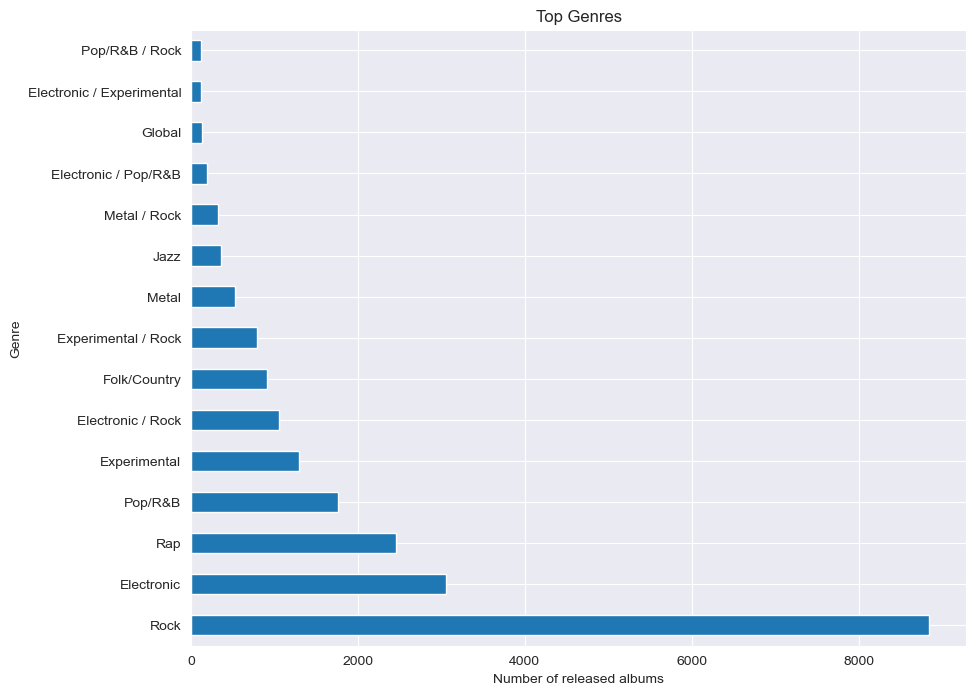

In [144]:
top_genres = data["genre"].value_counts().nlargest(15)
top_genres.plot(kind="barh", figsize=(10, 8))
plt.title("Top Genres")
plt.xlabel("Number of released albums")
plt.ylabel("Genre");

Rock is definitely on top! Now, for each of these genres, let's find the highest on average rated artist. We will only consider artists with more than 3 albums

In [161]:
artist_counts = data['artist_name'].value_counts()
artists_more_than_3 = artist_counts[artist_counts > 3].index

filtered_df = data[(data['genre'].isin(top_genres.index)) & (data['artist_name'].isin(artists_more_than_3))]
artist_genre_group = filtered_df.groupby(['genre', 'artist_name'])['score'].mean()

highest_rated_artist_per_genre = artist_genre_group.groupby('genre').idxmax() # highest rated artist in each genre
highest_avg_score = artist_genre_group.groupby('genre').max() # highest average score in each genre

for genre, artist, score in zip(highest_rated_artist_per_genre.index, highest_rated_artist_per_genre, highest_avg_score):
    print(f"Genre: {genre}\n\t Highest rated artist: {artist[1]}\n\t Average score: {score}")

Genre: Electronic
	 Highest rated artist: Luomo
	 Average score: 8.440000000000001
Genre: Electronic / Experimental
	 Highest rated artist: Susanna
	 Average score: 8.2
Genre: Electronic / Pop/R&B
	 Highest rated artist: FKA twigs
	 Average score: 8.52
Genre: Electronic / Rock
	 Highest rated artist: Brian Eno
	 Average score: 8.7
Genre: Experimental
	 Highest rated artist: Jan Jelinek
	 Average score: 8.4
Genre: Experimental / Rock
	 Highest rated artist: Animal Collective
	 Average score: 8.4
Genre: Folk/Country
	 Highest rated artist: Joanna Newsom
	 Average score: 8.76
Genre: Global
	 Highest rated artist: Caetano Veloso
	 Average score: 8.84
Genre: Jazz
	 Highest rated artist: John Coltrane
	 Average score: 9.157142857142857
Genre: Metal
	 Highest rated artist: Death
	 Average score: 9.1
Genre: Metal / Rock
	 Highest rated artist: The Dillinger Escape Plan
	 Average score: 8.4
Genre: Pop/R&B
	 Highest rated artist: Stevie Wonder
	 Average score: 9.142857142857142
Genre: Pop/R&B / 

Now lets see which artists released the most number of albums

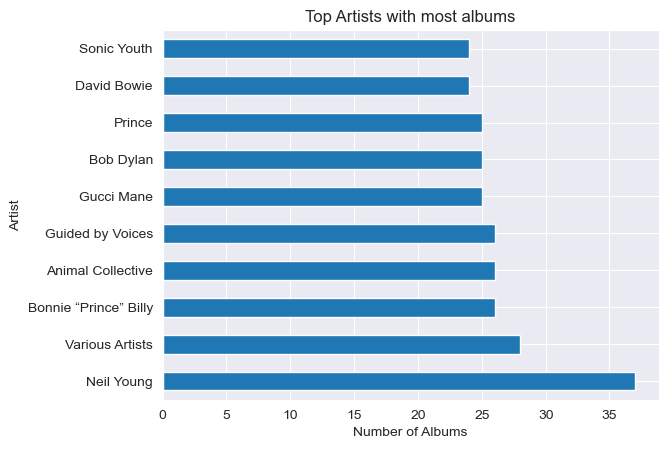

In [41]:
data['artist_name'].value_counts().nlargest(10).plot(kind='barh')
plt.title('Top Artists with most albums')
plt.xlabel('Number of Albums')
plt.ylabel('Artist')
plt.show()

# Corpus statistics

In [100]:
def calculate_corpus_stats(df: pd.Series) -> pd.DataFrame:
    len_ = df.str.len()
    n_digits = df.apply(lambda x: sum([symbol.isdigit() for symbol in x]))
    numbers_ratio = n_digits / len_
    n_words = df.str.split().str.len()
    n_letters = df.apply(lambda x: sum([symbol.isalpha() for symbol in x]))
    avg_word_len = n_letters / n_words
    n_spaces = df.str.count(' ')
    n_capitals = df.apply(lambda x: sum([symbol.isupper() for symbol in x]))
    capitals_ratio = n_capitals / n_words
    return pd.concat(
        [len_, n_digits, numbers_ratio, n_words, n_letters, avg_word_len, n_spaces, n_capitals, capitals_ratio],
        keys=['len', 'n_digits', 'numbers_ratio', 'n_words', 'n_letters', 'avg_word_len', 'n_spaces', 'n_capitals',
              'capitals_ratio'],
        axis=1
    )

In [102]:
stats = calculate_corpus_stats(data.text)
stats.describe()

,len,n_digits,numbers_ratio,n_words,n_letters,avg_word_len,n_spaces,n_capitals,capitals_ratio
count,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000,23426.000000
mean,4374.884359,14.533681,0.003148,710.424742,3491.548963,4.932309,707.370699,118.789123,0.167499
std,1775.013102,14.673243,0.002452,294.712968,1408.676523,0.215059,293.886226,57.231274,0.037670
min,117.000000,0.000000,0.000000,21.000000,90.000000,3.819932,20.000000,2.000000,0.039666
25%,3358.000000,5.000000,0.001391,541.000000,2686.000000,4.783670,539.000000,85.000000,0.142132
50%,4014.000000,11.000000,0.002662,650.000000,3209.000000,4.924307,647.000000,108.000000,0.164228
75%,4882.000000,19.000000,0.004366,794.000000,3897.000000,5.074920,790.750000,136.000000,0.188521
max,28414.000000,255.000000,0.031390,4575.000000,22598.000000,5.953216,4571.000000,921.000000,0.771293


Some insights:
- the average review length in ~4375 characters. But the length varies widely, with the sortest review being only 117 characters long, and the longest - 28.000 characters;
- each review contains on average 14 letters which form about 0.03% of the total review content. The review with the highest quantity of digits had 255 digits, amounting to about 3.1% of the total amount;
- reviews typically contain 710 words, and the average word length is 5 characters. This likely indicates the prevelance of relatively short, common words in text;
- the average number of spaces is around 707 which is quite close to the average word count and this is an expected behavior. Each review also includes an average of nearly 119 capitalized letters – about 16.7% of the review. Some reviews however contain as much as 77.1% capitalized letters which is unusually high and may be a point of interest for further investigation.

Let's investigate this particular strange album with 77.1% capitalized letters|

In [107]:
data.iloc[stats.capitals_ratio.argmax()].text

'Oh God, hang on to your tar pits, because leaping out from behind the Krispy Kreme pay phone comes a ...Oh God, hang on to your tar pits, because leaping out from behind the Krispy Kreme pay phone comes a selection of FUN FACTS ABOUT THIS CD! Read on!AMOUNT MERGE APPARENTLY SPENT ON THE PACKAGING: Thirty-five cents.POP ICON WHOM SUGGS MOST RESEMBLES: Matt is, fascinatingly, the lycanthropine doppelganger of the big brother from The Goonies.ARTIST THIS ALBUM MOST TRUMPS: Frank Black-- not to be confused with Black Francis or Charles Thompson. Amigo Row is the mature-but-not-boring, laid-way-back singer/songwriter album that Black\'s been struggling to half-make for years. Suggs\' embodiment of the Pixie-cum-pooper is uncanny, down to the lisp, spaciness, and the nervous, breathy falsetto. Intimations of Black Francis\' girl-name-dropping Bossanova do bubble up, though, as Suggs croons him some Clementines, Janies, and Hannahs.ARTIST MOST HAUNTING THIS ALBUM: Stephen Malkmus. Suggs\' ol

Apparently, there is nothing special about this review.
Let's see which words are the most and least common 

In [130]:
# remove punctuations and turn to lowercase
text = ' '.join(review for review in data['text'])
text = re.sub(r'[^\w\s]', ' ', text).lower()

words = text.split()
most_common = Counter(words).most_common(30)
most_common

[('the', 910781),
 ('of', 508925),
 ('a', 492271),
 ('and', 486126),
 ('s', 359046),
 ('to', 348512),
 ('in', 247520),
 ('that', 201833),
 ('it', 185113),
 ('is', 175442),
 ('on', 173763),
 ('with', 160521),
 ('as', 141877),
 ('for', 123064),
 ('but', 113266),
 ('his', 111743),
 ('like', 96193),
 ('from', 86094),
 ('he', 84327),
 ('you', 82232),
 ('an', 79507),
 ('their', 74063),
 ('i', 73452),
 ('album', 73179),
 ('this', 69512),
 ('t', 68113),
 ('they', 63217),
 ('are', 62661),
 ('at', 62396),
 ('by', 61708)]

As we can see this is not quite informative, as majority of the words are stopwords. Lets generate a wordcloud that ignores these words and creates a more representative distribution

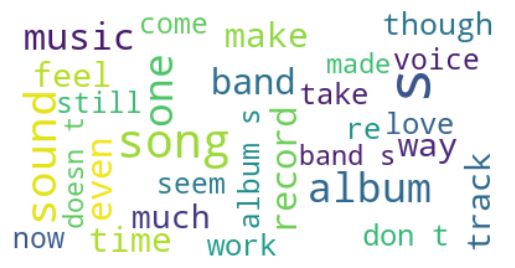

In [132]:
wordcloud = WordCloud(max_font_size=50, max_words=30, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

And the least common ones:

In [133]:
least_common = Counter(words).most_common()[:-31:-1]
least_common

[('sequitir', 1),
 ('gazingly', 1),
 ('sessionman', 1),
 ('mckeeve', 1),
 ('unpresumptuous', 1),
 ('kittel', 1),
 ('mertvykh', 1),
 ('semena', 1),
 ('jacquard', 1),
 ('reeeeeee', 1),
 ('snarked', 1),
 ('kabara', 1),
 ('deloach', 1),
 ('raharan', 1),
 ('eldam', 1),
 ('calcification', 1),
 ('headbandcore', 1),
 ('lumineersy', 1),
 ('overmatch', 1),
 ('pendelles', 1),
 ('bedtracks', 1),
 ('glamboyant', 1),
 ('soujourn', 1),
 ('xxiii', 1),
 ('lft', 1),
 ('sandlers', 1),
 ('tamra', 1),
 ('kiv', 1),
 ('sendups', 1),
 ('macgruber', 1)]